In [1]:
!hostname

amueller-tabpfn-4gpu


In [2]:
import sklearn
sklearn.__version__

'1.2.1'

In [3]:
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import numpy as np
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target)

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [5]:
from tabpfn.scripts.distill_mlp import TorchMLP, DistilledTabPFNMLP
from tabpfn.scripts.transformer_prediction_interface import TabPFNClassifier

In [6]:
TorchMLP(n_epochs=100).fit(X_train, y_train).score(X_test, y_test)

0.9210526315789473

In [7]:
import torch
torch.cuda.current_device()

0

In [8]:
torch.cuda.device_count()

4

In [23]:
from tabpfn.datasets import load_openml_list, open_cc_dids, open_cc_valid_dids, test_dids_classification

cc_valid_datasets_multiclass, cc_valid_datasets_multiclass_df = load_openml_list(open_cc_valid_dids, multiclass=True, shuffled=True, filter_for_nan=False, max_samples = 10000, num_feats=100, return_capped=True)

Number of datasets: 149


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


def make_mlp(categorical_features):
    cont_pipe = make_pipeline(StandardScaler(), SimpleImputer())
    preprocess = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features), remainder=cont_pipe)
    return make_pipeline(preprocess, TorchMLP(n_epochs=100))

def make_distilled_tabpfn(categorical_features):
    cont_pipe = make_pipeline(StandardScaler(), SimpleImputer())
    preprocess = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse_output=False, max_categories=10), categorical_features), remainder=cont_pipe)
    return make_pipeline(preprocess, DistilledTabPFNMLP(n_epochs=100, device="cuda"))

def make_distilled_tabpfn_ht(categorical_features):
    cont_pipe = make_pipeline(StandardScaler(), SimpleImputer())
    preprocess = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse_output=False, max_categories=10), categorical_features), remainder=cont_pipe)
    return make_pipeline(preprocess, DistilledTabPFNMLP(n_epochs=100, temperature=10, device="cuda"))


In [16]:
from tabpfn.scripts.evaluate_baselines_sklearn import make_logreg, make_knn, make_hgb, make_rf, make_tabpfn, make_mlp, make_distilled_tabpfn

In [17]:
models = {'mlp': make_mlp,
          'distilled_tabpfn': make_distilled_tabpfn,
         'distilled_tabpfn_ht': make_distilled_tabpfn_ht,

          'logreg': make_logreg,
            'knn': make_knn,
            'rf': make_rf,
            'tabpfn': make_tabpfn}

In [18]:
from tqdm import tqdm

In [22]:

from collections import defaultdict
all_scores = defaultdict(dict)
for ds_name, X, y, categorical_features, _, _ in tqdm(cc_valid_datasets_multiclass):
    print(ds_name)
    for model_name, model_creator in models.items():
        clf = model_creator(categorical_features)
        if X.shape[1] > 100:
            X = X[:, :100]
        try:
            scores = cross_validate(clf, X, y, scoring="roc_auc_ovo", n_jobs=-1)
            score = scores['test_score'].mean()
        except Exception as e:
            print(str(e))
            score = np.NaN
        all_scores[ds_name][model_name] = score

  0%|                                                                                                                                                                                                                                                 | 0/149 [00:00<?, ?it/s]

breast-cancer
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


  1%|█▌                                                                                                                                                                                                                                     | 1/149 [00:33<1:22:42, 33.53s/it]

colic
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


  1%|███                                                                                                                                                                                                                                    | 2/149 [01:08<1:24:20, 34.43s/it]

dermatology

All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/anaconda/envs/fresh311/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/anaconda/envs/fresh311/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/azureuser/TabPFN/tabpfn/scripts/distill_mlp.py", line 94, in fit
    tbfn = TabPFNClassifier(N_ensemble_configurations=32, temperature=self.temperature, device=self.device).fit(X, y)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  2%|████▋                                                                                                                                                                                                                                  | 3/149 [01:25<1:03:51, 26.24s/it]


All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/anaconda/envs/fresh311/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/anaconda/envs/fresh311/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/azureuser/TabPFN/tabpfn/scripts/transformer_prediction_interface.py", line 197, in fit
    raise ValueError("The number of features for this classifier is restricted to ", self.max_num_features)
ValueError: ('The number of features for this classifier is restricted to ', 100)

sonar
Multiple models in mem

  3%|██████▎                                                                                                                                                                                                                                  | 4/149 [01:45<57:24, 23.76s/it]

glass
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


  3%|███████▊                                                                                                                                                                                                                                 | 5/149 [02:03<52:33, 21.90s/it]

haberman
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


  4%|█████████▍                                                                                                                                                                                                                               | 6/149 [02:26<53:06, 22.29s/it]

tae
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


  5%|██████████▉                                                                                                                                                                                                                              | 7/149 [02:45<49:58, 21.12s/it]

heart-c
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


  5%|████████████▌                                                                                                                                                                                                                            | 8/149 [03:11<53:33, 22.79s/it]

heart-h
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


  6%|██████████████                                                                                                                                                                                                                           | 9/149 [03:39<56:39, 24.28s/it]

heart-statlog
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


  7%|███████████████▌                                                                                                                                                                                                                        | 10/149 [04:04<56:35, 24.43s/it]

hepatitis
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


  7%|█████████████████▏                                                                                                                                                                                                                      | 11/149 [04:23<52:38, 22.89s/it]

vote
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lea

  8%|██████████████████▋                                                                                                                                                                                                                     | 12/149 [04:53<57:27, 25.17s/it]

ionosphere
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


  9%|████████████████████▏                                                                                                                                                                                                                   | 13/149 [05:17<56:12, 24.79s/it]

iris
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


  9%|█████████████████████▊                                                                                                                                                                                                                  | 14/149 [05:34<50:34, 22.48s/it]

wine
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 10%|███████████████████████▎                                                                                                                                                                                                                | 15/149 [05:54<48:01, 21.51s/it]

hayes-roth
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This mig

 11%|████████████████████████▉                                                                                                                                                                                                               | 16/149 [06:12<45:31, 20.53s/it]

monks-problems-1
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 11%|██████████████████████████▍                                                                                                                                                                                                             | 17/149 [06:49<56:19, 25.60s/it]

monks-problems-2
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. Th

 12%|███████████████████████████▊                                                                                                                                                                                                          | 18/149 [07:30<1:05:47, 30.13s/it]

monks-problems-3
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 13%|█████████████████████████████▎                                                                                                                                                                                                        | 19/149 [08:07<1:09:26, 32.05s/it]

SPECT
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might le

 13%|██████████████████████████████▊                                                                                                                                                                                                       | 20/149 [08:32<1:04:26, 29.97s/it]

SPECTF
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might l

 14%|████████████████████████████████▍                                                                                                                                                                                                     | 21/149 [09:00<1:03:11, 29.62s/it]

grub-damage
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This mi

 15%|██████████████████████████████████▎                                                                                                                                                                                                     | 22/149 [09:19<55:46, 26.35s/it]

synthetic_control
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. T

 15%|███████████████████████████████████▌                                                                                                                                                                                                  | 23/149 [10:01<1:05:08, 31.02s/it]

prnn_crabs
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 16%|█████████████████████████████████████▎                                                                                                                                                                                                  | 24/149 [10:18<55:45, 26.77s/it]

analcatdata_lawsuit
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 17%|██████████████████████████████████████▉                                                                                                                                                                                                 | 25/149 [10:41<52:52, 25.58s/it]

irish
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 17%|████████████████████████████████████████▍                                                                                                                                                                                               | 26/149 [11:18<59:43, 29.13s/it]

analcatdata_broadwaymult
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 18%|██████████████████████████████████████████                                                                                                                                                                                              | 27/149 [11:43<56:46, 27.92s/it]

analcatdata_reviewer
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 19%|███████████████████████████████████████████▌                                                                                                                                                                                            | 28/149 [12:12<56:40, 28.10s/it]

backache
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 19%|█████████████████████████████████████████████▏                                                                                                                                                                                          | 29/149 [12:32<51:31, 25.77s/it]

prnn_synth
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This mig

 20%|██████████████████████████████████████████████▋                                                                                                                                                                                         | 30/149 [12:48<45:10, 22.78s/it]

schizo
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 21%|████████████████████████████████████████████████▎                                                                                                                                                                                       | 31/149 [13:16<48:08, 24.48s/it]

profb
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might le

 21%|█████████████████████████████████████████████████▊                                                                                                                                                                                      | 32/149 [13:58<57:29, 29.48s/it]

analcatdata_germangss
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 22%|███████████████████████████████████████████████████▍                                                                                                                                                                                    | 33/149 [14:27<56:52, 29.42s/it]

biomed
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 23%|████████████████████████████████████████████████████▉                                                                                                                                                                                   | 34/149 [14:50<52:45, 27.52s/it]

rmftsa_sleepdata
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. Th

 23%|██████████████████████████████████████████████████████                                                                                                                                                                                | 35/149 [15:38<1:04:04, 33.72s/it]

diggle_table_a2
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 24%|████████████████████████████████████████████████████████                                                                                                                                                                                | 36/149 [16:05<59:54, 31.81s/it]

rmftsa_ladata
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 25%|█████████████████████████████████████████████████████████                                                                                                                                                                             | 37/149 [16:44<1:03:14, 33.88s/it]

pwLinear
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 26%|███████████████████████████████████████████████████████████▏                                                                                                                                                                            | 38/149 [17:04<55:03, 29.76s/it]

Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
analcatdata_vineyard
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 26%|████████████████████████████████████████████████████████████▋                                                                                                                                                                           | 39/149 [17:38<56:32, 30.84s/it]

machine_cpu
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 27%|██████████████████████████████████████████████████████████████▎                                                                                                                                                                         | 40/149 [17:54<48:17, 26.58s/it]

pharynx
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 28%|███████████████████████████████████████████████████████████████▊                                                                                                                                                                        | 41/149 [18:18<46:12, 25.67s/it]

auto_price
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This mig

 28%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 42/149 [18:38<42:43, 23.96s/it]

servo
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 29%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                                     | 43/149 [18:55<38:53, 22.02s/it]

analcatdata_wildcat
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 30%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 44/149 [19:16<37:37, 21.50s/it]

pm10
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lea

 30%|██████████████████████████████████████████████████████████████████████                                                                                                                                                                  | 45/149 [19:48<42:59, 24.80s/it]

wisconsin
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 31%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                                                | 46/149 [20:10<41:09, 23.98s/it]

autoPrice
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 32%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                              | 47/149 [20:30<38:30, 22.66s/it]

meta
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lea

 32%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                                                             | 48/149 [21:08<46:03, 27.36s/it]

analcatdata_apnea3
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 33%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 49/149 [21:40<48:05, 28.86s/it]

analcatdata_apnea2
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. 

 34%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                          | 50/149 [22:13<49:34, 30.04s/it]

analcatdata_apnea1
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 34%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 51/149 [22:51<52:52, 32.37s/it]

disclosure_x_bias
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 35%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                       | 52/149 [23:20<50:48, 31.43s/it]

bodyfat
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 36%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 53/149 [23:44<46:22, 28.98s/it]

cleveland
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 36%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                    | 54/149 [24:05<42:21, 26.75s/it]

triazines
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 37%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 55/149 [24:29<40:21, 25.76s/it]

disclosure_x_tampered
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 38%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                | 56/149 [24:51<38:22, 24.75s/it]

cpu
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 38%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                               | 57/149 [25:10<35:18, 23.03s/it]

cholesterol
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This mi

 39%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                             | 58/149 [25:34<35:22, 23.32s/it]

chscase_funds
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This 

 40%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                            | 59/149 [25:48<30:36, 20.40s/it]

pbcseq

All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/anaconda/envs/fresh311/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/anaconda/envs/fresh311/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/azureuser/TabPFN/tabpfn/scripts/distill_mlp.py", line 94, in fit
    tbfn = TabPFNClassifier(N_ensemble_configurations=32, temperature=self.temperature, device=self.device).fit(X, y)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

 40%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                          | 60/149 [26:04<28:43, 19.37s/it]


All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/anaconda/envs/fresh311/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/anaconda/envs/fresh311/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/azureuser/TabPFN/tabpfn/scripts/transformer_prediction_interface.py", line 201, in fit
    raise ValueError("⚠️ WARNING: TabPFN is not made for datasets with a trainingsize > 1024. Prediction might take a while, be less reliable. We advise not to run datasets > 10k samples, which might lead to your machin

 41%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                         | 61/149 [26:37<34:04, 23.24s/it]

rmftsa_ctoarrivals
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 42%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 62/149 [27:00<33:38, 23.20s/it]

chscase_vine2
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 42%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 63/149 [27:21<32:29, 22.66s/it]

chatfield_4
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 43%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 64/149 [27:44<32:08, 22.68s/it]

boston_corrected
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 65/149 [28:21<37:41, 26.92s/it]

sensory
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might 

 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 66/149 [29:01<42:49, 30.96s/it]

disclosure_x_noise
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. 

 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 67/149 [29:27<40:13, 29.43s/it]

autoMpg
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                              | 68/149 [30:01<41:23, 30.66s/it]

kdd_el_nino-small
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. T

 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 69/149 [30:52<49:00, 36.76s/it]

Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
autoHorse
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This migh

 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 70/149 [31:13<42:13, 32.07s/it]

stock
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might le

 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 71/149 [32:14<53:01, 40.78s/it]

breastTumor
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 72/149 [32:39<46:13, 36.02s/it]

analcatdata_gsssexsurvey
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 73/149 [32:58<39:08, 30.91s/it]

boston
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 74/149 [33:33<40:14, 32.19s/it]

fishcatch
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 75/149 [33:48<33:33, 27.22s/it]

vinnie
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 76/149 [34:07<29:53, 24.57s/it]

mu284
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 77/149 [34:31<29:19, 24.44s/it]

no2
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead

 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 78/149 [35:03<31:36, 26.72s/it]

chscase_geyser1
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 79/149 [35:19<27:15, 23.36s/it]

chscase_census6
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. Thi

 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 80/149 [35:46<28:08, 24.46s/it]

chscase_census5
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. Thi

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 81/149 [36:14<28:58, 25.57s/it]

chscase_census4
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. Thi

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 82/149 [36:43<29:44, 26.63s/it]

chscase_census3
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. Thi

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 83/149 [37:12<30:09, 27.42s/it]

chscase_census2
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 84/149 [37:41<30:19, 27.99s/it]

plasma_retinol
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 85/149 [38:11<30:21, 28.45s/it]

visualizing_galaxy
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 86/149 [38:30<26:47, 25.51s/it]

colleges_usnews
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()

All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/anaconda/envs/fresh311/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/anaconda/envs/fresh311/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/azureuser/TabPFN/tabpfn/scripts/distill_mlp.py", line 94, in fit
    tbfn = Ta

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 87/149 [38:47<23:42, 22.94s/it]


All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/anaconda/envs/fresh311/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/anaconda/envs/fresh311/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/azureuser/TabPFN/tabpfn/scripts/transformer_prediction_interface.py", line 201, in fit
    raise ValueError("⚠️ WARNING: TabPFN is not made for datasets with a trainingsize > 1024. Prediction might take a while, be less reliable. We advise not to run datasets > 10k samples, which might lead to your machin

 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 88/149 [39:13<24:29, 24.08s/it]

socmob
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 89/149 [40:31<40:07, 40.13s/it]

chscase_whale
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 90/149 [40:50<33:18, 33.88s/it]

water-treatment

All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/anaconda/envs/fresh311/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/anaconda/envs/fresh311/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/azureuser/TabPFN/tabpfn/scripts/distill_mlp.py", line 94, in fit
    tbfn = TabPFNClassifier(N_ensemble_configurations=32, temperature=self.temperature, device=self.device).fit(X, y)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 91/149 [41:07<27:48, 28.78s/it]


All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/anaconda/envs/fresh311/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/anaconda/envs/fresh311/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/azureuser/TabPFN/tabpfn/scripts/transformer_prediction_interface.py", line 197, in fit
    raise ValueError("The number of features for this classifier is restricted to ", self.max_num_features)
ValueError: ('The number of features for this classifier is restricted to ', 100)

lowbwt
Multiple models in me

 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 92/149 [41:27<24:47, 26.10s/it]

arsenic-female-bladder
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


/anaconda/envs/fresh311/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 93/149 [42:02<26:56, 28.87s/it]

analcatdata_halloffame

All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/anaconda/envs/fresh311/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/anaconda/envs/fresh311/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/azureuser/TabPFN/tabpfn/scripts/distill_mlp.py", line 94, in fit
    tbfn = TabPFNClassifier(N_ensemble_configurations=32, temperature=self.temperature, device=self.device).fit(X, y)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 94/149 [42:15<21:56, 23.93s/it]


All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/anaconda/envs/fresh311/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/anaconda/envs/fresh311/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/azureuser/TabPFN/tabpfn/scripts/transformer_prediction_interface.py", line 201, in fit
    raise ValueError("⚠️ WARNING: TabPFN is not made for datasets with a trainingsize > 1024. Prediction might take a while, be less reliable. We advise not to run datasets > 10k samples, which might lead to your machin

 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 95/149 [42:42<22:26, 24.93s/it]

analcatdata_draft
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 96/149 [43:10<22:57, 25.99s/it]

collins
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 97/149 [43:47<25:14, 29.12s/it]

prnn_fglass
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This mi

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 98/149 [44:09<22:59, 27.06s/it]

jEdit_4.2_4.3
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 99/149 [44:40<23:28, 28.18s/it]

mc2
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 100/149 [44:57<20:12, 24.74s/it]

mw1
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 101/149 [45:29<21:36, 27.01s/it]

jEdit_4.0_4.2
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 102/149 [45:56<21:05, 26.93s/it]

PopularKids
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 103/149 [46:30<22:22, 29.18s/it]

teachingAssistant
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 104/149 [46:49<19:36, 26.15s/it]

lungcancer_GSE31210
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 105/149 [47:11<18:19, 24.98s/it]

MegaWatt1
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 106/149 [47:35<17:36, 24.57s/it]

PizzaCutter1
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                 | 107/149 [48:19<21:11, 30.28s/it]

PizzaCutter3
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                               | 108/149 [49:27<28:31, 41.73s/it]

CostaMadre1
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                              | 109/149 [49:48<23:40, 35.52s/it]

CastMetal1
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This mig

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 110/149 [50:19<22:09, 34.08s/it]

KnuggetChase3
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 111/149 [50:40<19:11, 30.29s/it]

PieChart1
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This migh

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 112/149 [51:28<21:51, 35.46s/it]

PieChart3
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 113/149 [52:39<27:40, 46.11s/it]

Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
parkinsons
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This mig

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 114/149 [53:01<22:43, 38.97s/it]

planning-relax
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 115/149 [53:25<19:36, 34.60s/it]

qualitative-bankruptcy
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 116/149 [53:48<17:04, 31.03s/it]

sa-heart
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 117/149 [54:23<17:11, 32.24s/it]

seeds
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 118/149 [54:41<14:25, 27.93s/it]

thoracic-surgery
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 119/149 [55:14<14:46, 29.56s/it]

user-knowledge
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 120/149 [55:43<14:06, 29.17s/it]

wholesale-customers
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 121/149 [56:13<13:45, 29.49s/it]

heart-long-beach
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. Th

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 122/149 [56:35<12:13, 27.17s/it]

robot-failures-lp5
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. 

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 123/149 [56:55<10:54, 25.16s/it]

vertebra-column
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. Thi

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 124/149 [57:20<10:27, 25.09s/it]

Smartphone-Based_Recognition_of_Human_Activities
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 125/149 [57:41<09:35, 23.99s/it]

breast-cancer-dropped-missing-attributes-values
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 126/149 [58:04<09:03, 23.63s/it]

LED-display-domain-7digit
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in m

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 127/149 [58:39<09:49, 26.81s/it]

GAMETES_Epistasis_2-Way_20atts_0.1H_EDM-1_1

All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/anaconda/envs/fresh311/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/anaconda/envs/fresh311/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/azureuser/TabPFN/tabpfn/scripts/distill_mlp.py", line 94, in fit
    tbfn = TabPFNClassifier(N_ensemble_configurations=32, temperature=self.temperature, device=self.device).fit(X, y)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 128/149 [58:53<08:07, 23.23s/it]


All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/anaconda/envs/fresh311/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/anaconda/envs/fresh311/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/azureuser/TabPFN/tabpfn/scripts/transformer_prediction_interface.py", line 201, in fit
    raise ValueError("⚠️ WARNING: TabPFN is not made for datasets with a trainingsize > 1024. Prediction might take a while, be less reliable. We advise not to run datasets > 10k samples, which might lead to your machin

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 129/149 [59:07<06:46, 20.34s/it]


All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/anaconda/envs/fresh311/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/anaconda/envs/fresh311/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/azureuser/TabPFN/tabpfn/scripts/transformer_prediction_interface.py", line 197, in fit
    raise ValueError("The number of features for this classifier is restricted to ", self.max_num_features)
ValueError: ('The number of features for this classifier is restricted to ', 100)

corral
Multiple models in me

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 130/149 [59:26<06:19, 19.96s/it]

mofn-3-7-10

All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/anaconda/envs/fresh311/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/anaconda/envs/fresh311/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/azureuser/TabPFN/tabpfn/scripts/distill_mlp.py", line 94, in fit
    tbfn = TabPFNClassifier(N_ensemble_configurations=32, temperature=self.temperature, device=self.device).fit(X, y)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 131/149 [59:38<05:17, 17.64s/it]


All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/anaconda/envs/fresh311/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/anaconda/envs/fresh311/lib/python3.11/site-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/azureuser/TabPFN/tabpfn/scripts/transformer_prediction_interface.py", line 201, in fit
    raise ValueError("⚠️ WARNING: TabPFN is not made for datasets with a trainingsize > 1024. Prediction might take a while, be less reliable. We advise not to run datasets > 10k samples, which might lead to your machin

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 132/149 [59:59<05:17, 18.67s/it]

solar-flare
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 133/149 [1:00:25<05:34, 20.88s/it]

threeOf9
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 134/149 [1:01:00<06:16, 25.10s/it]

xd6
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 135/149 [1:02:03<08:28, 36.35s/it]

tokyo1
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 136/149 [1:03:09<09:46, 45.14s/it]

parity5_plus_5
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 137/149 [1:04:25<10:53, 54.45s/it]

cleve
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might le

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 138/149 [1:04:53<08:33, 46.71s/it]

cleveland-nominal
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 139/149 [1:05:19<06:42, 40.27s/it]

Australian
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This mig

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 140/149 [1:06:08<06:26, 42.98s/it]

DiabeticMellitus
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 141/149 [1:06:32<04:57, 37.20s/it]

conference_attendance
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 142/149 [1:06:54<03:49, 32.80s/it]

CPMP-2015-runtime-classification
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple mode

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 143/149 [1:07:31<03:24, 34.12s/it]

TuningSVMs
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 144/149 [1:07:51<02:28, 29.61s/it]

regime_alimentaire
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 145/149 [1:08:15<01:51, 27.93s/it]

iris-example
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 146/149 [1:08:30<01:13, 24.35s/it]

Touch2
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 147/149 [1:08:53<00:47, 23.70s/it]

penguins
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 148/149 [1:09:22<00:25, 25.40s/it]

titanic
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might lead to memory issues. Consider calling remove_models_from_memory()
Multiple models in memory. This might 

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [1:10:20<00:00, 28.33s/it]


In [23]:
import pandas as pd
results = pd.DataFrame.from_dict(all_scores).T

In [24]:
results.isna().sum()

mlp                    0
distilled_tabpfn       8
distilled_tabpfn_ht    8
logreg                 0
knn                    0
rf                     0
tabpfn                 8
dtype: int64

In [25]:
results.to_csv("sklearn_implementation_baselines_auc_redo.cvs")

In [26]:
results.dropna()

,mlp,distilled_tabpfn,distilled_tabpfn_ht,logreg,knn,rf,tabpfn
breast-cancer,0.705165,0.719032,0.718443,0.694928,0.637934,0.683816,0.722461
colic,0.885905,0.885719,0.885253,0.875698,0.847037,0.913075,0.894787
sonar,0.934220,0.947244,0.947698,0.870630,0.897559,0.928207,0.947794
glass,0.903652,0.905528,0.905942,0.881423,0.878902,0.944137,0.938821
haberman,0.673186,0.723971,0.723954,0.662810,0.645131,0.684003,0.711667
...,...,...,...,...,...,...,...
regime_alimentaire,0.949590,0.945944,0.945944,0.961458,0.901349,0.955579,0.927367
iris-example,0.995333,0.997000,0.997000,0.997333,0.991500,0.995333,0.997000
Touch2,0.973185,0.981328,0.981394,0.952478,0.949996,0.979879,0.988497
penguins,0.999797,0.999797,0.999797,0.999797,0.999638,0.999152,0.999797


In [27]:
bla  = results.dropna().stack().reset_index()
bla.columns = ['dataset_name', 'classifier_name', 'accuracy']
bla

,dataset_name,classifier_name,accuracy
0,breast-cancer,mlp,0.705165
1,breast-cancer,distilled_tabpfn,0.719032
2,breast-cancer,distilled_tabpfn_ht,0.718443
3,breast-cancer,logreg,0.694928
4,breast-cancer,knn,0.637934
...,...,...,...
982,titanic,distilled_tabpfn_ht,0.866366
983,titanic,logreg,0.854819
984,titanic,knn,0.850946
985,titanic,rf,0.866552


['mlp' 'distilled_tabpfn' 'distilled_tabpfn_ht' 'logreg' 'knn' 'rf'
 'tabpfn']
distilled_tabpfn        5.0
distilled_tabpfn_ht     5.0
knn                     2.0
logreg                 24.0
mlp                    15.0
rf                     31.0
tabpfn                 38.0
dtype: float64
knn                    6.014184
mlp                    4.443262
logreg                 4.191489
rf                     3.762411
distilled_tabpfn       3.432624
distilled_tabpfn_ht    3.418440
tabpfn                 2.737589
dtype: float64
('knn', 'tabpfn', 1.1568307081455343e-18, True)
('distilled_tabpfn_ht', 'knn', 2.0717995978850566e-16, True)
('distilled_tabpfn', 'knn', 2.2572501479523486e-16, True)
('knn', 'rf', 6.370377301692491e-16, True)
('knn', 'mlp', 1.2135631770967177e-10, True)
('mlp', 'tabpfn', 1.7342425414048873e-08, True)
('logreg', 'tabpfn', 3.161740467328801e-08, True)
('knn', 'logreg', 6.977317169530739e-07, True)
('distilled_tabpfn_ht', 'mlp', 1.855626359200013e-06, True)
('distilled

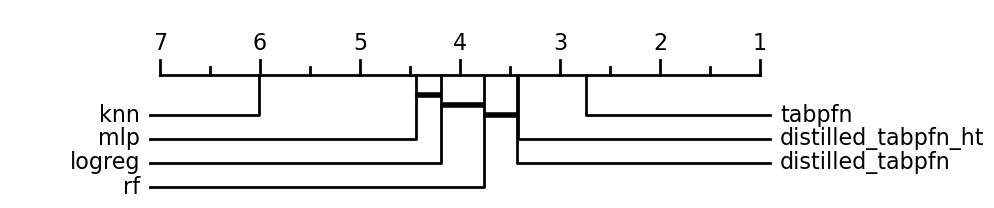

In [29]:
from tabpfn.scripts.critical_differences import draw_cd_diagram
res = draw_cd_diagram(bla, title="OVO ROC AUC")

In [9]:
import pandas as pd
results = pd.read_csv("sklearn_implementation_baselines_auc_redo.cvs", index_col=0)

In [10]:
from lightgbm import LGBMClassifier

In [11]:
def make_lgbm(categorical_features):
    return LGBMClassifier(categorical_features=categorical_features)

In [12]:
def make_mlp_shallow(categorical_features):
    cont_pipe = make_pipeline(StandardScaler(), SimpleImputer())
    preprocess = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features), remainder=cont_pipe)
    return make_pipeline(preprocess, TorchMLP(n_epochs=100, hidden_size=128, n_layers=1))

def make_distilled_tabpfn_shallow(categorical_features):
    cont_pipe = make_pipeline(StandardScaler(), SimpleImputer())
    preprocess = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse_output=False, max_categories=10), categorical_features), remainder=cont_pipe)
    return make_pipeline(preprocess, DistilledTabPFNMLP(n_epochs=100, device="cuda", hidden_size=128, n_layers=1))

def make_mlp_big(categorical_features):
    cont_pipe = make_pipeline(StandardScaler(), SimpleImputer())
    preprocess = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features), remainder=cont_pipe)
    return make_pipeline(preprocess, TorchMLP(n_epochs=100, hidden_size=1024, n_layers=4))

def make_distilled_tabpfn_big(categorical_features):
    cont_pipe = make_pipeline(StandardScaler(), SimpleImputer())
    preprocess = make_column_transformer((OneHotEncoder(handle_unknown='ignore', sparse_output=False, max_categories=10), categorical_features), remainder=cont_pipe)
    return make_pipeline(preprocess, DistilledTabPFNMLP(n_epochs=100, device="cuda", hidden_size=1024, n_layers=4))


In [19]:
models = {'mlp': make_mlp,
          'mlp_shallow': make_mlp_shallow,
          'mlp_big': make_mlp_big,
          'distilled_tabpfn': make_distilled_tabpfn,
         'distilled_tabpfn_ht': make_distilled_tabpfn_ht,
           'distilled_tabpfn_shallow': make_distilled_tabpfn_shallow,
         'distilled_tabpfn_big': make_distilled_tabpfn_big,

          'logreg': make_logreg,
            'knn': make_knn,
            'rf': make_rf,
            'tabpfn': make_tabpfn}

In [20]:
for model in models:
    if model not in results.columns:
        results[model] = np.NaN

In [21]:
results

,mlp,distilled_tabpfn,distilled_tabpfn_ht,logreg,knn,rf,tabpfn,mlp_shallow,mlp_big,distilled_tabpfn_shallow,distilled_tabpfn_big
breast-cancer,0.705165,0.719032,0.718443,0.694928,0.637934,0.683816,0.722461,NaN,NaN,NaN,NaN
colic,0.885905,0.885719,0.885253,0.875698,0.847037,0.913075,0.894787,NaN,NaN,NaN,NaN
dermatology,0.998480,NaN,NaN,0.998870,0.996039,0.999330,NaN,NaN,NaN,NaN,NaN
sonar,0.934220,0.947244,0.947698,0.870630,0.897559,0.928207,0.947794,NaN,NaN,NaN,NaN
glass,0.903652,0.905528,0.905942,0.881423,0.878902,0.944137,0.938821,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
regime_alimentaire,0.949590,0.945944,0.945944,0.961458,0.901349,0.955579,0.927367,NaN,NaN,NaN,NaN
iris-example,0.995333,0.997000,0.997000,0.997333,0.991500,0.995333,0.997000,NaN,NaN,NaN,NaN
Touch2,0.973185,0.981328,0.981394,0.952478,0.949996,0.979879,0.988497,NaN,NaN,NaN,NaN
penguins,0.999797,0.999797,0.999797,0.999797,0.999638,0.999152,0.999797,NaN,NaN,NaN,NaN


In [24]:
from sklearn.model_selection import cross_validate

for ds_name, X, y, categorical_features, _, _ in tqdm(cc_valid_datasets_multiclass):
    print(ds_name)
    for model_name, model_creator in models.items():
        if not np.isnan(results.loc[ds_name, model_name]):
            continue
        print(model_name)
        clf = model_creator(categorical_features)
        if X.shape[1] > 100:
            X = X[:, :100]
        try:
            scores = cross_validate(clf, X, y, scoring="roc_auc_ovo", error_score="raise")
            score = scores['test_score'].mean()
        except Exception as e:
            print(str(e))
            score = np.NaN
        results.loc[ds_name, model_name] = score

  0%|                                                                                                                                                                                                                                                 | 0/149 [00:00<?, ?it/s]

breast-cancer
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


  1%|█▌                                                                                                                                                                                                                                     | 1/149 [00:28<1:09:46, 28.29s/it]

colic
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


  1%|███                                                                                                                                                                                                                                    | 2/149 [00:59<1:13:07, 29.85s/it]

dermatology
mlp_shallow
mlp_big
distilled_tabpfn
('The number of features for this classifier is restricted to ', 100)
distilled_tabpfn_ht
('The number of features for this classifier is restricted to ', 100)
distilled_tabpfn_shallow
('The number of features for this classifier is restricted to ', 100)
distilled_tabpfn_big
('The number of features for this classifier is restricted to ', 100)
tabpfn


  2%|████▋                                                                                                                                                                                                                                  | 3/149 [01:50<1:36:48, 39.78s/it]

('The number of features for this classifier is restricted to ', 100)
sonar
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


  3%|██████▏                                                                                                                                                                                                                                | 4/149 [02:17<1:24:02, 34.78s/it]

glass
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


  3%|███████▊                                                                                                                                                                                                                               | 5/149 [02:43<1:15:14, 31.35s/it]

haberman
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


  4%|█████████▎                                                                                                                                                                                                                             | 6/149 [03:12<1:13:03, 30.65s/it]

tae
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


  5%|██████████▊                                                                                                                                                                                                                            | 7/149 [03:37<1:08:00, 28.73s/it]

heart-c
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


  5%|████████████▍                                                                                                                                                                                                                          | 8/149 [04:07<1:08:45, 29.26s/it]

heart-h
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


  6%|█████████████▉                                                                                                                                                                                                                         | 9/149 [04:39<1:09:56, 29.97s/it]

CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 79.10 GiB total capacity; 126.17 MiB already allocated; 60.56 MiB free; 134.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
heart-statlog
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


  7%|███████████████▍                                                                                                                                                                                                                      | 10/149 [05:07<1:08:24, 29.53s/it]

hepatitis
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


  7%|████████████████▉                                                                                                                                                                                                                     | 11/149 [05:31<1:03:33, 27.63s/it]

vote
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


  8%|██████████████████▌                                                                                                                                                                                                                   | 12/149 [06:03<1:06:20, 29.05s/it]

ionosphere
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


  9%|████████████████████                                                                                                                                                                                                                  | 13/149 [06:35<1:07:43, 29.88s/it]

iris
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


  9%|█████████████████████▌                                                                                                                                                                                                                | 14/149 [07:08<1:09:21, 30.83s/it]

CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 79.10 GiB total capacity; 23.05 MiB already allocated; 54.56 MiB free; 24.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
wine
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 10%|███████████████████████▏                                                                                                                                                                                                              | 15/149 [07:34<1:05:39, 29.40s/it]

hayes-roth
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 11%|████████████████████████▋                                                                                                                                                                                                             | 16/149 [07:57<1:01:06, 27.57s/it]

monks-problems-1
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 11%|██████████████████████████▏                                                                                                                                                                                                           | 17/149 [08:34<1:06:51, 30.39s/it]

monks-problems-2
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 12%|███████████████████████████▊                                                                                                                                                                                                          | 18/149 [09:13<1:11:46, 32.88s/it]

monks-problems-3
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 13%|█████████████████████████████▎                                                                                                                                                                                                        | 19/149 [09:50<1:14:02, 34.17s/it]

CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

SPECT
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 13%|██████████████████████████████▊                                                                                                                                                                                                       | 20/149 [10:19<1:09:57, 32.54s/it]

SPECTF
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 14%|████████████████████████████████▍                                                                                                                                                                                                     | 21/149 [10:49<1:07:47, 31.78s/it]

grub-damage
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 15%|█████████████████████████████████▉                                                                                                                                                                                                    | 22/149 [11:13<1:02:22, 29.47s/it]

synthetic_control
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 15%|███████████████████████████████████▌                                                                                                                                                                                                  | 23/149 [11:53<1:08:45, 32.74s/it]

prnn_crabs
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 16%|█████████████████████████████████████                                                                                                                                                                                                 | 24/149 [12:26<1:08:21, 32.81s/it]

CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

analcatdata_lawsuit
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 17%|██████████████████████████████████████▌                                                                                                                                                                                               | 25/149 [12:55<1:05:33, 31.72s/it]

irish
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 17%|████████████████████████████████████████▏                                                                                                                                                                                             | 26/149 [13:30<1:07:07, 32.74s/it]

analcatdata_broadwaymult
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 18%|█████████████████████████████████████████▋                                                                                                                                                                                            | 27/149 [13:59<1:03:55, 31.44s/it]

analcatdata_reviewer
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 19%|███████████████████████████████████████████▏                                                                                                                                                                                          | 28/149 [14:31<1:03:48, 31.64s/it]

backache
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 19%|████████████████████████████████████████████▊                                                                                                                                                                                         | 29/149 [15:03<1:03:39, 31.83s/it]

CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

prnn_synth
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 20%|██████████████████████████████████████████████▎                                                                                                                                                                                       | 30/149 [15:32<1:01:10, 30.85s/it]

schizo
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 21%|████████████████████████████████████████████████▎                                                                                                                                                                                       | 31/149 [16:01<59:44, 30.38s/it]

profb
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 21%|█████████████████████████████████████████████████▍                                                                                                                                                                                    | 32/149 [16:43<1:05:50, 33.77s/it]

analcatdata_germangss
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 22%|██████████████████████████████████████████████████▉                                                                                                                                                                                   | 33/149 [17:16<1:04:57, 33.60s/it]

biomed
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 23%|████████████████████████████████████████████████████▍                                                                                                                                                                                 | 34/149 [17:49<1:03:52, 33.33s/it]

CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

rmftsa_sleepdata
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 23%|██████████████████████████████████████████████████████                                                                                                                                                                                | 35/149 [18:43<1:15:35, 39.79s/it]

diggle_table_a2
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 24%|███████████████████████████████████████████████████████▌                                                                                                                                                                              | 36/149 [19:12<1:08:35, 36.42s/it]

rmftsa_ladata
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 25%|█████████████████████████████████████████████████████████                                                                                                                                                                             | 37/149 [19:48<1:07:58, 36.42s/it]

pwLinear
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 26%|██████████████████████████████████████████████████████████▋                                                                                                                                                                           | 38/149 [20:15<1:01:56, 33.48s/it]

analcatdata_vineyard
mlp_shallow
mlp_big
distilled_tabpfn_shallow
CUDA out of memory. Tried to allocate 48.00 MiB (GPU 0; 79.10 GiB total capacity; 333.00 MiB already allocated; 47.56 MiB free; 400.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
distilled_tabpfn_big


 26%|████████████████████████████████████████████████████████████▏                                                                                                                                                                         | 39/149 [21:04<1:10:00, 38.19s/it]

machine_cpu
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 27%|█████████████████████████████████████████████████████████████▋                                                                                                                                                                        | 40/149 [21:29<1:01:52, 34.06s/it]

pharynx
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 28%|███████████████████████████████████████████████████████████████▊                                                                                                                                                                        | 41/149 [21:54<56:25, 31.34s/it]

auto_price
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 28%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                                      | 42/149 [22:18<52:12, 29.27s/it]

servo
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 29%|██████████████████████████████████████████████████████████████████▉                                                                                                                                                                     | 43/149 [22:43<49:30, 28.03s/it]

analcatdata_wildcat
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 30%|████████████████████████████████████████████████████████████████████▌                                                                                                                                                                   | 44/149 [23:06<46:06, 26.34s/it]

pm10
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 30%|██████████████████████████████████████████████████████████████████████                                                                                                                                                                  | 45/149 [23:39<49:12, 28.39s/it]

CUDA error: CUBLAS_STATUS_NOT_INITIALIZED when calling `cublasCreate(handle)`
wisconsin
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 31%|███████████████████████████████████████████████████████████████████████▌                                                                                                                                                                | 46/149 [24:05<47:36, 27.73s/it]

autoPrice
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 32%|█████████████████████████████████████████████████████████████████████████▏                                                                                                                                                              | 47/149 [24:28<44:35, 26.23s/it]

meta
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 32%|██████████████████████████████████████████████████████████████████████████▋                                                                                                                                                             | 48/149 [25:05<49:38, 29.49s/it]

analcatdata_apnea3
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 33%|████████████████████████████████████████████████████████████████████████████▎                                                                                                                                                           | 49/149 [25:40<52:09, 31.30s/it]

analcatdata_apnea2
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 34%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                          | 50/149 [26:19<55:03, 33.37s/it]

CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

analcatdata_apnea1
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 34%|███████████████████████████████████████████████████████████████████████████████▍                                                                                                                                                        | 51/149 [26:55<56:01, 34.30s/it]

disclosure_x_bias
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 35%|████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                                       | 52/149 [27:35<58:01, 35.89s/it]

bodyfat
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 36%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                                     | 53/149 [28:02<53:13, 33.27s/it]

cleveland
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 36%|████████████████████████████████████████████████████████████████████████████████████                                                                                                                                                    | 54/149 [28:32<51:12, 32.34s/it]

triazines
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 37%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                                  | 55/149 [29:04<50:40, 32.35s/it]

CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

disclosure_x_tampered
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 38%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                | 56/149 [29:46<54:41, 35.28s/it]

cpu
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 38%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                               | 57/149 [30:11<49:24, 32.22s/it]

cholesterol
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 39%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                             | 58/149 [30:41<47:30, 31.33s/it]

chscase_funds
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 40%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                            | 59/149 [31:06<44:27, 29.64s/it]

pbcseq
mlp_shallow
mlp_big
distilled_tabpfn
⚠️ WARNING: TabPFN is not made for datasets with a trainingsize > 1024. Prediction might take a while, be less reliable. We advise not to run datasets > 10k samples, which might lead to your machine crashing (due to quadratic memory scaling of TabPFN). Please confirm you want to run by passing overwrite_warning=True to the fit function.
distilled_tabpfn_ht
⚠️ WARNING: TabPFN is not made for datasets with a trainingsize > 1024. Prediction might take a while, be less reliable. We advise not to run datasets > 10k samples, which might lead to your machine crashing (due to quadratic memory scaling of TabPFN). Please confirm you want to run by passing overwrite_warning=True to the fit function.
distilled_tabpfn_shallow
⚠️ WARNING: TabPFN is not made for datasets with a trainingsize > 1024. Prediction might take a while, be less reliable. We advise not to run datasets > 10k samples, which might lead to your machine crashing (due to quadratic memory 

 40%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                         | 60/149 [32:38<1:11:34, 48.26s/it]

⚠️ WARNING: TabPFN is not made for datasets with a trainingsize > 1024. Prediction might take a while, be less reliable. We advise not to run datasets > 10k samples, which might lead to your machine crashing (due to quadratic memory scaling of TabPFN). Please confirm you want to run by passing overwrite_warning=True to the fit function.
pbc
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 41%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                       | 61/149 [33:12<1:04:36, 44.05s/it]

rmftsa_ctoarrivals
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 42%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                                       | 62/149 [33:40<56:43, 39.13s/it]

chscase_vine2
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 42%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                      | 63/149 [34:15<54:18, 37.88s/it]

chatfield_4
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 43%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                    | 64/149 [34:42<49:15, 34.77s/it]

boston_corrected
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 44%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 65/149 [35:21<50:20, 35.96s/it]

CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

sensory
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 44%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                 | 66/149 [36:00<50:55, 36.82s/it]

disclosure_x_noise
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 45%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                               | 67/149 [36:40<51:39, 37.80s/it]

autoMpg
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                              | 68/149 [37:13<49:01, 36.32s/it]

kdd_el_nino-small
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 46%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                            | 69/149 [37:59<52:28, 39.35s/it]

autoHorse
mlp_shallow
mlp_big
distilled_tabpfn_shallow
CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

distilled_tabpfn_big


 47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                           | 70/149 [38:39<51:47, 39.34s/it]

stock
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 48%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                         | 71/149 [39:30<55:44, 42.88s/it]

breastTumor
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                        | 72/149 [39:58<49:31, 38.59s/it]

analcatdata_gsssexsurvey
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                      | 73/149 [40:23<43:21, 34.24s/it]

boston
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 74/149 [41:00<43:57, 35.16s/it]

fishcatch
mlp_shallow
mlp_big
distilled_tabpfn_shallow
CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

distilled_tabpfn_big


 50%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                   | 75/149 [41:35<43:17, 35.11s/it]

vinnie
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 51%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                 | 76/149 [42:05<40:53, 33.60s/it]

mu284
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                | 77/149 [42:33<38:17, 31.92s/it]

no2
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                              | 78/149 [43:09<39:08, 33.08s/it]

chscase_geyser1
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 79/149 [43:36<36:41, 31.45s/it]

chscase_census6
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                           | 80/149 [44:13<38:00, 33.05s/it]

CUDA error: CUBLAS_STATUS_NOT_INITIALIZED when calling `cublasCreate(handle)`
chscase_census5
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                          | 81/149 [44:47<37:44, 33.30s/it]

chscase_census4
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 55%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                        | 82/149 [45:18<36:29, 32.68s/it]

chscase_census3
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 83/149 [45:50<35:45, 32.50s/it]

chscase_census2
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 84/149 [46:23<35:23, 32.66s/it]

plasma_retinol
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 85/149 [46:58<35:28, 33.26s/it]

CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

visualizing_galaxy
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                  | 86/149 [47:29<34:11, 32.56s/it]

colleges_usnews
mlp_shallow
mlp_big
distilled_tabpfn
⚠️ WARNING: TabPFN is not made for datasets with a trainingsize > 1024. Prediction might take a while, be less reliable. We advise not to run datasets > 10k samples, which might lead to your machine crashing (due to quadratic memory scaling of TabPFN). Please confirm you want to run by passing overwrite_warning=True to the fit function.
distilled_tabpfn_ht
⚠️ WARNING: TabPFN is not made for datasets with a trainingsize > 1024. Prediction might take a while, be less reliable. We advise not to run datasets > 10k samples, which might lead to your machine crashing (due to quadratic memory scaling of TabPFN). Please confirm you want to run by passing overwrite_warning=True to the fit function.
distilled_tabpfn_shallow
⚠️ WARNING: TabPFN is not made for datasets with a trainingsize > 1024. Prediction might take a while, be less reliable. We advise not to run datasets > 10k samples, which might lead to your machine crashing (due to quadrati

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 87/149 [48:36<44:28, 43.04s/it]

⚠️ WARNING: TabPFN is not made for datasets with a trainingsize > 1024. Prediction might take a while, be less reliable. We advise not to run datasets > 10k samples, which might lead to your machine crashing (due to quadratic memory scaling of TabPFN). Please confirm you want to run by passing overwrite_warning=True to the fit function.
disclosure_z
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 59%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 88/149 [49:19<43:30, 42.79s/it]

socmob
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                             | 89/149 [50:17<47:21, 47.36s/it]

chscase_whale
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 90/149 [50:43<40:20, 41.03s/it]

water-treatment
mlp_shallow
mlp_big
distilled_tabpfn
('The number of features for this classifier is restricted to ', 100)
distilled_tabpfn_ht
('The number of features for this classifier is restricted to ', 100)
distilled_tabpfn_shallow
('The number of features for this classifier is restricted to ', 100)
distilled_tabpfn_big
('The number of features for this classifier is restricted to ', 100)
tabpfn


 61%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                          | 91/149 [51:50<47:21, 48.99s/it]

('The number of features for this classifier is restricted to ', 100)
lowbwt
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 92/149 [52:17<40:15, 42.37s/it]

arsenic-female-bladder
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 93/149 [52:55<38:09, 40.88s/it]

analcatdata_halloffame
mlp_shallow
mlp_big
distilled_tabpfn
⚠️ WARNING: TabPFN is not made for datasets with a trainingsize > 1024. Prediction might take a while, be less reliable. We advise not to run datasets > 10k samples, which might lead to your machine crashing (due to quadratic memory scaling of TabPFN). Please confirm you want to run by passing overwrite_warning=True to the fit function.
distilled_tabpfn_ht
⚠️ WARNING: TabPFN is not made for datasets with a trainingsize > 1024. Prediction might take a while, be less reliable. We advise not to run datasets > 10k samples, which might lead to your machine crashing (due to quadratic memory scaling of TabPFN). Please confirm you want to run by passing overwrite_warning=True to the fit function.
distilled_tabpfn_shallow
⚠️ WARNING: TabPFN is not made for datasets with a trainingsize > 1024. Prediction might take a while, be less reliable. We advise not to run datasets > 10k samples, which might lead to your machine crashing (due to q

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 94/149 [54:05<45:32, 49.68s/it]

⚠️ WARNING: TabPFN is not made for datasets with a trainingsize > 1024. Prediction might take a while, be less reliable. We advise not to run datasets > 10k samples, which might lead to your machine crashing (due to quadratic memory scaling of TabPFN). Please confirm you want to run by passing overwrite_warning=True to the fit function.
analcatdata_birthday
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                    | 95/149 [54:38<40:03, 44.52s/it]

analcatdata_draft
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 96/149 [55:08<35:37, 40.33s/it]

collins
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                 | 97/149 [55:44<33:44, 38.92s/it]

prnn_fglass
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                               | 98/149 [56:10<29:59, 35.28s/it]

jEdit_4.2_4.3
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 99/149 [56:46<29:29, 35.39s/it]

CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

mc2
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 100/149 [57:12<26:37, 32.60s/it]

mw1
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 101/149 [57:44<25:56, 32.43s/it]

jEdit_4.0_4.2
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                        | 102/149 [58:12<24:24, 31.17s/it]

PopularKids
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 103/149 [58:49<25:04, 32.71s/it]

teachingAssistant
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 104/149 [59:21<24:27, 32.61s/it]

CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

lungcancer_GSE31210
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                    | 105/149 [59:49<22:55, 31.25s/it]

MegaWatt1
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                  | 106/149 [1:00:16<21:27, 29.95s/it]

PizzaCutter1
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 107/149 [1:00:58<23:22, 33.39s/it]

PizzaCutter3
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                               | 108/149 [1:01:54<27:31, 40.28s/it]

CostaMadre1
mlp_shallow
mlp_big
distilled_tabpfn_shallow
CUDA error: CUBLAS_STATUS_NOT_INITIALIZED when calling `cublasCreate(handle)`
distilled_tabpfn_big


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 109/149 [1:02:38<27:30, 41.27s/it]

CastMetal1
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                            | 110/149 [1:03:06<24:24, 37.54s/it]

KnuggetChase3
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                          | 111/149 [1:03:31<21:24, 33.80s/it]

PieChart1
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 112/149 [1:04:15<22:37, 36.69s/it]

PieChart3
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 113/149 [1:05:05<24:26, 40.74s/it]

CUDA error: CUBLAS_STATUS_NOT_INITIALIZED when calling `cublasCreate(handle)`
parkinsons
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 114/149 [1:05:32<21:21, 36.62s/it]

planning-relax
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 115/149 [1:05:56<18:34, 32.79s/it]

qualitative-bankruptcy
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 116/149 [1:06:22<16:58, 30.87s/it]

sa-heart
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 117/149 [1:06:58<17:16, 32.38s/it]

seeds
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 118/149 [1:07:33<17:02, 32.99s/it]

CUDA out of memory. Tried to allocate 12.00 MiB (GPU 0; 79.10 GiB total capacity; 107.83 MiB already allocated; 54.56 MiB free; 116.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
thoracic-surgery
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 119/149 [1:08:09<17:04, 34.16s/it]

user-knowledge
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 120/149 [1:08:42<16:13, 33.56s/it]

wholesale-customers
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 121/149 [1:09:16<15:44, 33.75s/it]

heart-long-beach
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 122/149 [1:09:42<14:12, 31.58s/it]

robot-failures-lp5
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 123/149 [1:10:16<13:53, 32.06s/it]

CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

vertebra-column
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 124/149 [1:10:47<13:13, 31.74s/it]

Smartphone-Based_Recognition_of_Human_Activities
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 125/149 [1:11:11<11:49, 29.58s/it]

breast-cancer-dropped-missing-attributes-values
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 126/149 [1:11:39<11:08, 29.08s/it]

LED-display-domain-7digit
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 127/149 [1:12:17<11:39, 31.81s/it]

GAMETES_Epistasis_2-Way_20atts_0.1H_EDM-1_1
mlp_shallow
mlp_big
distilled_tabpfn
⚠️ WARNING: TabPFN is not made for datasets with a trainingsize > 1024. Prediction might take a while, be less reliable. We advise not to run datasets > 10k samples, which might lead to your machine crashing (due to quadratic memory scaling of TabPFN). Please confirm you want to run by passing overwrite_warning=True to the fit function.
distilled_tabpfn_ht
⚠️ WARNING: TabPFN is not made for datasets with a trainingsize > 1024. Prediction might take a while, be less reliable. We advise not to run datasets > 10k samples, which might lead to your machine crashing (due to quadratic memory scaling of TabPFN). Please confirm you want to run by passing overwrite_warning=True to the fit function.
distilled_tabpfn_shallow
⚠️ WARNING: TabPFN is not made for datasets with a trainingsize > 1024. Prediction might take a while, be less reliable. We advise not to run datasets > 10k samples, which might lead to your machi

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 128/149 [1:13:38<16:19, 46.64s/it]

⚠️ WARNING: TabPFN is not made for datasets with a trainingsize > 1024. Prediction might take a while, be less reliable. We advise not to run datasets > 10k samples, which might lead to your machine crashing (due to quadratic memory scaling of TabPFN). Please confirm you want to run by passing overwrite_warning=True to the fit function.
calendarDOW
mlp_shallow
mlp_big
distilled_tabpfn
('The number of features for this classifier is restricted to ', 100)
distilled_tabpfn_ht
('The number of features for this classifier is restricted to ', 100)
distilled_tabpfn_shallow
('The number of features for this classifier is restricted to ', 100)
distilled_tabpfn_big
('The number of features for this classifier is restricted to ', 100)
tabpfn


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 129/149 [1:14:34<16:26, 49.33s/it]

('The number of features for this classifier is restricted to ', 100)
corral
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 130/149 [1:14:59<13:20, 42.14s/it]

mofn-3-7-10
mlp_shallow
mlp_big
distilled_tabpfn
⚠️ WARNING: TabPFN is not made for datasets with a trainingsize > 1024. Prediction might take a while, be less reliable. We advise not to run datasets > 10k samples, which might lead to your machine crashing (due to quadratic memory scaling of TabPFN). Please confirm you want to run by passing overwrite_warning=True to the fit function.
distilled_tabpfn_ht
⚠️ WARNING: TabPFN is not made for datasets with a trainingsize > 1024. Prediction might take a while, be less reliable. We advise not to run datasets > 10k samples, which might lead to your machine crashing (due to quadratic memory scaling of TabPFN). Please confirm you want to run by passing overwrite_warning=True to the fit function.
distilled_tabpfn_shallow
⚠️ WARNING: TabPFN is not made for datasets with a trainingsize > 1024. Prediction might take a while, be less reliable. We advise not to run datasets > 10k samples, which might lead to your machine crashing (due to quadratic me

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 131/149 [1:16:06<14:52, 49.60s/it]

⚠️ WARNING: TabPFN is not made for datasets with a trainingsize > 1024. Prediction might take a while, be less reliable. We advise not to run datasets > 10k samples, which might lead to your machine crashing (due to quadratic memory scaling of TabPFN). Please confirm you want to run by passing overwrite_warning=True to the fit function.
thyroid-new
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 132/149 [1:16:34<12:12, 43.11s/it]

solar-flare
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 133/149 [1:17:02<10:17, 38.62s/it]

threeOf9
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 134/149 [1:17:38<09:25, 37.67s/it]

xd6
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 135/149 [1:18:31<09:51, 42.26s/it]

tokyo1
mlp_shallow
mlp_big
distilled_tabpfn_shallow
CUDA out of memory. Tried to allocate 24.00 MiB (GPU 0; 79.10 GiB total capacity; 321.79 MiB already allocated; 47.56 MiB free; 348.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
distilled_tabpfn_big


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 136/149 [1:19:37<10:41, 49.31s/it]

parity5_plus_5
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 137/149 [1:20:33<10:17, 51.42s/it]

cleve
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 138/149 [1:21:02<08:12, 44.78s/it]

cleveland-nominal
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 139/149 [1:21:32<06:41, 40.19s/it]

Australian
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 140/149 [1:22:13<06:05, 40.56s/it]

CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

DiabeticMellitus
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 141/149 [1:22:44<05:00, 37.54s/it]

conference_attendance
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 142/149 [1:23:10<03:59, 34.18s/it]

CPMP-2015-runtime-classification
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 143/149 [1:23:47<03:29, 34.97s/it]

TuningSVMs
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 144/149 [1:24:12<02:40, 32.01s/it]

regime_alimentaire
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 145/149 [1:24:46<02:10, 32.66s/it]

CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 79.10 GiB total capacity; 8.02 MiB already allocated; 52.56 MiB free; 22.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF
iris-example
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 146/149 [1:25:12<01:31, 30.59s/it]

Touch2
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 147/149 [1:25:39<00:58, 29.47s/it]

penguins
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 148/149 [1:26:10<00:30, 30.01s/it]

titanic
mlp_shallow
mlp_big
distilled_tabpfn_shallow
distilled_tabpfn_big


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 149/149 [1:27:02<00:00, 35.05s/it]


In [ ]:
res.isna().sum()